In [1]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
img_idx = 1

data = unpickle("../Data/cifar-10-batches-py/data_batch_1")
img = data[b'data'][img_idx].reshape(3, 32, 32)
label = data[b'labels'][img_idx]
labels = unpickle("../Data/cifar-10-batches-py/batches.meta")[b'label_names']
labels[label]

b'truck'

1. Extracting patches...
2. Adapting GMM to image statistics


/Users/thanasis/mamba/envs/New_env/lib/python3.13/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


3. Denoising patches...
4. Reconstructing image from patches...


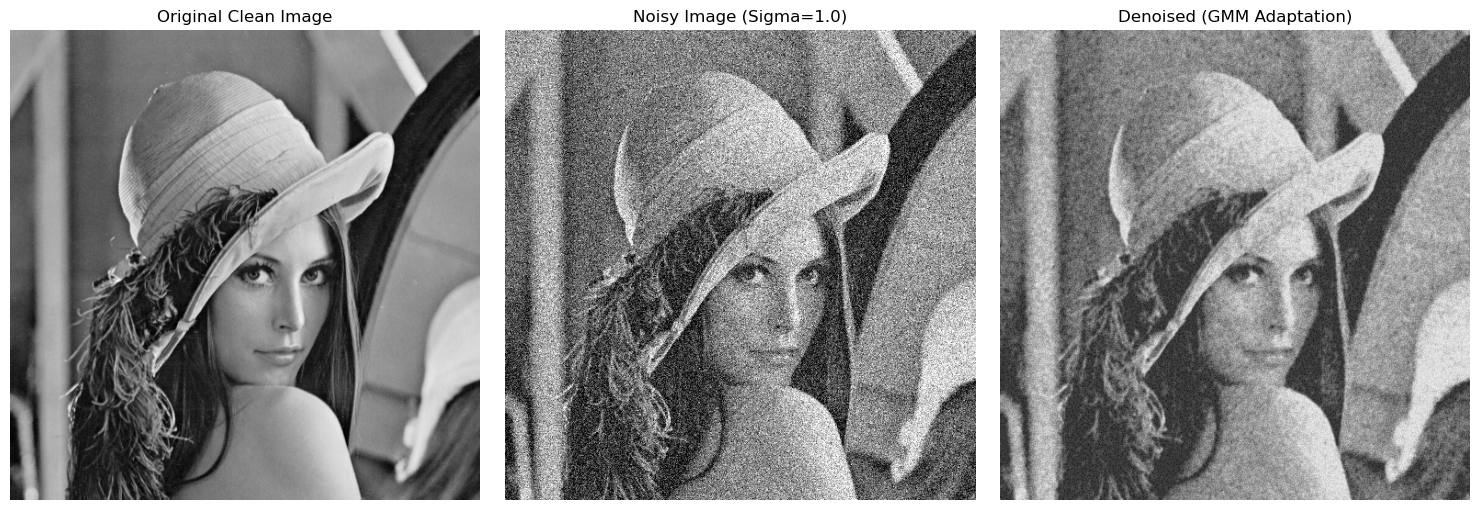

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.mixture import GaussianMixture
from skimage.util import view_as_windows
from skimage import data
from skimage.restoration import denoise_nl_means
import cv2

def adaptive_gmm_denoising(noisy_image, patch_size=(8, 8), n_components=16, n_iter=5):
    """
    A simplified demonstration of GMM-based Adaptive Denoising.
    
    1. EXTRACT: Breaks image into 8x8 overlapping patches.
    2. ADAPT: Fits a GMM to these specific noisy patches (Learning the "Internal Prior").
    3. RECONSTRUCT: Uses the model to predict clean patches and averages them.
    """
    
    # --- Step 1: Extract Patches ---
    print("1. Extracting patches...")
    height, width = noisy_image.shape
    # Extract overlapping patches (this creates thousands of small 8x8 squares)
    patches = extract_patches_2d(noisy_image, patch_size)
    
    # Flatten patches for the GMM (n_samples, n_features)
    # 8x8 patch becomes a vector of size 64
    patches_flat = patches.reshape(patches.shape[0], -1)
    
    # --- Step 2: Mixture Adaptation (The "Learning" Phase) ---
    print("2. Adapting GMM to image statistics")
    
    # In the actual paper, they start with a "Generic Prior" (pre-trained GMM)
    # and adapt it. Here, we simulate that by training a GMM directly on the 
    # noisy patches to learn the specific textures of THIS image.
    # This is direct from noisy image but should in the future start from clean prior
    gmm = GaussianMixture(n_components=n_components, 
                          covariance_type='full', 
                          max_iter=n_iter, 
                          warm_start=False)
    
    # We fit the model to our noisy patches
    gmm.fit(patches_flat)
    
    # --- Step 3: Denoise Patches (Wiener Filtering / Projection) ---
    print("3. Denoising patches...")
    
    # In a full implementation, we would use the GMM covariances to perform 
    # Wiener filtering. For this simplified demo, we use the GMM to predict 
    # the most likely "clean" cluster for each patch and reconstruct from means.
    
    # Predict which Gaussian component each patch belongs to
    labels = gmm.predict(patches_flat)
    
    # Replace each noisy patch with the "mean" of its assigned Gaussian component
    # (This is a simplified approximation of the paper's reconstruction step)
    denoised_patches_flat = gmm.means_[labels]
    
    # Reshape back to square patches
    denoised_patches = denoised_patches_flat.reshape(patches.shape)
    
    # --- Step 4: Reconstruct Image ---
    print("4. Reconstructing image from patches...")
    # Overlapping patches are averaged together to smooth out seams
    reconstructed_image = reconstruct_from_patches_2d(denoised_patches, (height, width))
    
    return reconstructed_image

# --- Run the Demo ---

# 1. Load a sample clean image (Camera man)
clean_image = cv2.imread('../../data/Set12/08.png', 0)  # Load grayscale

# 2. Add Gaussian Noise
sigma = 1.0  # Noise level
noisy_image = clean_image + sigma*np.random.normal(0, 40, clean_image.shape)
noisy_image = np.clip(noisy_image, 0, 255) # Keep pixel values between 0 and 1

# 3. Run the Algorithm
denoised_image = adaptive_gmm_denoising(noisy_image, patch_size=(4, 4), n_components=1000, n_iter=30)

# 4. Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(clean_image, cmap='gray')
axes[0].set_title("Original Clean Image")
axes[0].axis('off')

axes[1].imshow(noisy_image, cmap='gray')
axes[1].set_title(f"Noisy Image (Sigma={sigma})")
axes[1].axis('off')

axes[2].imshow(denoised_image, cmap='gray')
axes[2].set_title("Denoised (GMM Adaptation)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [34]:
clean_image = cv2.imread('../01.png', 0)  # Load grayscale

clean_image

# import matplotlib.pyplot as plt

# # Transpose from (3, 32, 32) to (32, 32, 3) for matplotlib
# img_display = clean_image

# plt.imshow(img_display, cmap="gray")
# plt.axis('off')
# plt.title('CIFAR-10 Image')
# plt.show()

array([[156, 159, 158, ..., 151, 152, 152],
       [160, 154, 157, ..., 154, 155, 153],
       [156, 159, 158, ..., 151, 152, 152],
       ...,
       [114, 132, 123, ..., 135, 137, 114],
       [121, 126, 130, ..., 133, 130, 113],
       [121, 126, 130, ..., 133, 130, 113]], shape=(256, 256), dtype=uint8)